In [1]:
!pip install baselines

  Using cached https://files.pythonhosted.org/packages/cf/8c/64e0630b3d450244feef0688d90eab2448631e40ba6bdbd90a70b84898e7/mujoco-py-1.50.1.68.tar.gz
  ERROR: Failed building wheel for mujoco-py
  Running setup.py clean for mujoco-py
Failed to build mujoco-py
    Running setup.py install for mujoco-py ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-5ut7iwim/mujoco-py/setup.py'"'"'; __file__='"'"'/tmp/pip-install-5ut7iwim/mujoco-py/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-0t7h372h/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

import matplotlib.pyplot as plt
import numpy as np
import random
import math

from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import gym
from IPython.display import clear_output
%matplotlib inline

plt.rcParams.update({'font.size': 18})

In [3]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)
USE_CUDA

True

In [4]:
class wrap_pytorch(gym.ObservationWrapper):
    """
    Image shape to num_channels x weight x height
    """
    def __init__(self, env):
        super(wrap_pytorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.uint8)

    def observation(self, observation):
        return np.swapaxes(observation, 2, 0)

env = make_atari("VideoPinballNoFrameskip-v0")
env = wrap_deepmind(env, frame_stack=True)
env = wrap_pytorch(env)
print('State shape: {}'.format(env.observation_space.shape))
print('Action shape: {}'.format(env.action_space.n))

State shape: (4, 84, 84)
Action shape: 9


In [0]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [0]:
'''The convolution network used in the experiment is exactly the one
proposed by proposed by Mnih et al. (2015), we only provide de-
tails here for completeness. The input to the network is a 84x84x4
tensor containing a rescaled, and gray-scale, version of the last four
frames. The first convolution layer convolves the input with 32 fil-
ters of size 8 (stride 4), the second layer has 64 layers of size 4
(stride 2), the final convolution layer has 64 filters of size 3 (stride
1). This is followed by a fully-connected hidden layer of 512 units.
All these layers are separated by Rectifier Linear Units (ReLu). Fi-
nally, a fully-connected linear layer projects to the output of the
network, i.e., the Q-values. The optimization employed to train the
network is RMSProp (with momentum parameter 0.95).'''
class ConvDQN(nn.Module):
  def __init__(self, input_shape, num_actions):
    super(ConvDQN, self).__init__()
    self.action_mask = [True, True, False, True, True, True, False, False, False]
    self.action_mask_inv = [not x for x in self.action_mask]
    assert input_shape == (4,84,84) #Atari Preprocessing

    self.input_shape = input_shape #(4,84,84)
    self.num_actions = num_actions

    self.convs = nn.Sequential(
      nn.Conv2d(in_channels=self.input_shape[0],
                out_channels=32,
                kernel_size=(8,8),
                stride=4) ,               #(32,20,20)
      nn.ReLU(),
      nn.Conv2d(in_channels=32,
                out_channels=64,
                kernel_size=(4,4),
                stride=2)  ,              #(64,9,9)
      nn.ReLU(),
      nn.Conv2d(in_channels=64,
                out_channels=64,
                kernel_size=(3,3),
                stride=1)   ,             #(64,7,7)
      nn.ReLU()
    )

    self.fcs = nn.Sequential(
      nn.Linear(in_features=7*7*64,
                out_features=512),
      nn.ReLU(),
      nn.Linear(in_features=512,
                out_features=self.num_actions)
    )

  def forward(self, x):
      x = self.convs(x)
      x = x.view(-1, 7*7*64)
      x = self.fcs(x)
      return x

  def act(self, state, epsilon):
    with torch.no_grad():
      state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0))
      q_value = self.forward(state)
    q_value[0][self.action_mask_inv] = -np.inf #add an action mask to never perform certain actions
    max_q_val = q_value.max().item()
    action  = q_value.max(1)[1].data[0]
    if random.random() < epsilon:
      while True :
        action = random.randrange(env.action_space.n)
        if self.action_mask[action]:
          break
    return action,max_q_val

In [0]:
def compute_td_loss(gamma, batch_size):
  state, action, reward, next_state, done = replay_buffer.sample(batch_size)

  state      = Variable(torch.FloatTensor(np.float32(state)))
  next_state = Variable(torch.FloatTensor(np.float32(next_state)))
  action     = Variable(torch.LongTensor(action))
  reward     = Variable(torch.FloatTensor(reward))
  done       = Variable(torch.FloatTensor(done))

  #for regular dqn we take the max action from the target network rather 
  #than the online network
  #next_q_val = online_network(next_state)

  
  next_target_values= target_network(next_state)
  #next_target_action = torch.max(next_target_values, 1)[1].unsqueeze(1)
  #estimated_next_q_val = next_target_values.gather(1, next_online_action).squeeze()
  next_target_max_val = torch.max(next_target_values, 1)[0]

  #td_target = Variable((reward+gamma*estimated_next_q_val*(1-done)).data)
  td_target = Variable((reward+gamma*next_target_max_val*(1-done)).data)
  current_q_val = online_network(state)

  q_value = current_q_val.gather(1, action.unsqueeze(1)).squeeze(1)

  #loss_fn = nn.SmoothL1Loss()
  #td_loss = loss_fn(td_target,q_value)
  td_loss = (q_value-td_target).pow(2).mean()

  optimizer.zero_grad()
  td_loss.backward()
  optimizer.step()
    
  return td_loss

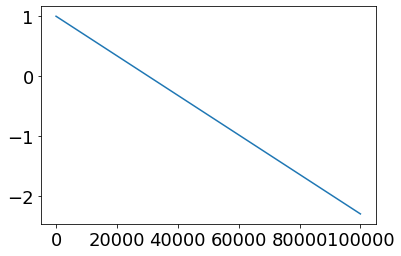

In [8]:
def update_target(online_network, target_network):
    target_network.load_state_dict(online_network.state_dict())

def get_epsilon(start,end,decay_length):
  '''
  Linear decay of epsilon over specified amount of timesteps
  '''
  timestep = 0
  eps_decrease = (start-end)/decay_length
  epsilon = start
  while True:
    yield epsilon
    timestep+=1
    #epsilon = end + (start - end) * math.exp(-1. * timestep / decay_length)
    epsilon+=-eps_decrease

get_eps = get_epsilon(1,0.01,30000)
x = [next(get_eps) for i in range(100000)]
plt.plot(x)

In [0]:
# Modify/Set Hyperparameters for NN's 
class hasselt_hyp:
  '''
  Hyperparameters according to DDQN paper from Hasselt et al 2015
  '''
  def __init__(self):
    #self.optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00025,
                                                # momentum=0.95)
    self.learning_rate=0.00025
    self.momentum=0.95
    self.num_iterations = 350000
    self.target_update_period = 1000
    self.gamma = 0.99
    self.replay_buffer_max_length = 200000
    self.collect_steps_per_iteration = 4 
    self.batch_size = 32
    self.log_interval = 20000
    self.num_eval_episodes = 50
    self.eval_interval = 1000000
    #self.size_of_replay_memory=30000
    #calvin - I'm adding these hyperparams?
    self.epsilon_start = 1
    self.epsilon_end = 0.1
    self.epsilon_decay_period=80000
    self.update_freq = 4

In [30]:
save_online_path = 'video_pinball_dqn_online.pth'
online_network=ConvDQN(env.observation_space.shape, env.action_space.n)
try:
  online_network.load_state_dict(torch.load(save_online_path))
  print('Using model from {}'.format(save_online_path))
except:
  pass
target_network=ConvDQN(env.observation_space.shape, env.action_space.n)

if USE_CUDA:
  print('Using GPU')
  online_network = online_network.cuda()
  target_network = target_network.cuda()

hyp = hasselt_hyp()
optimizer = optim.RMSprop(lr=hyp.learning_rate,
                          momentum=hyp.momentum,
                          params=online_network.parameters())

Using model from video_pinball_dqn_online.pth
Using GPU


In [0]:

def plot(rewards, loss, max_q_values):
  clear_output(True)
  fig1,ax1 = plt.subplots(1,3, figsize=(30,10))

  ax1[0].plot(rewards)
  ax1[0].set_title('Rewards per Episode')
  ax1[0].set_xlabel('Episode')
  ax1[0].set_ylabel('Reward')
  
  ax1[1].plot(loss)
  ax1[1].set_title('DQN Loss')
  ax1[1].set_ylabel('Loss')
  ax1[1].set_xlabel('Timesteps')

  ax1[2].plot(max_q_values)
  ax1[2].set_title('Max Q Values')
  ax1[2].set_ylabel('Max Action Value')
  ax1[2].set_xlabel('Timesteps')  
  plt.show()

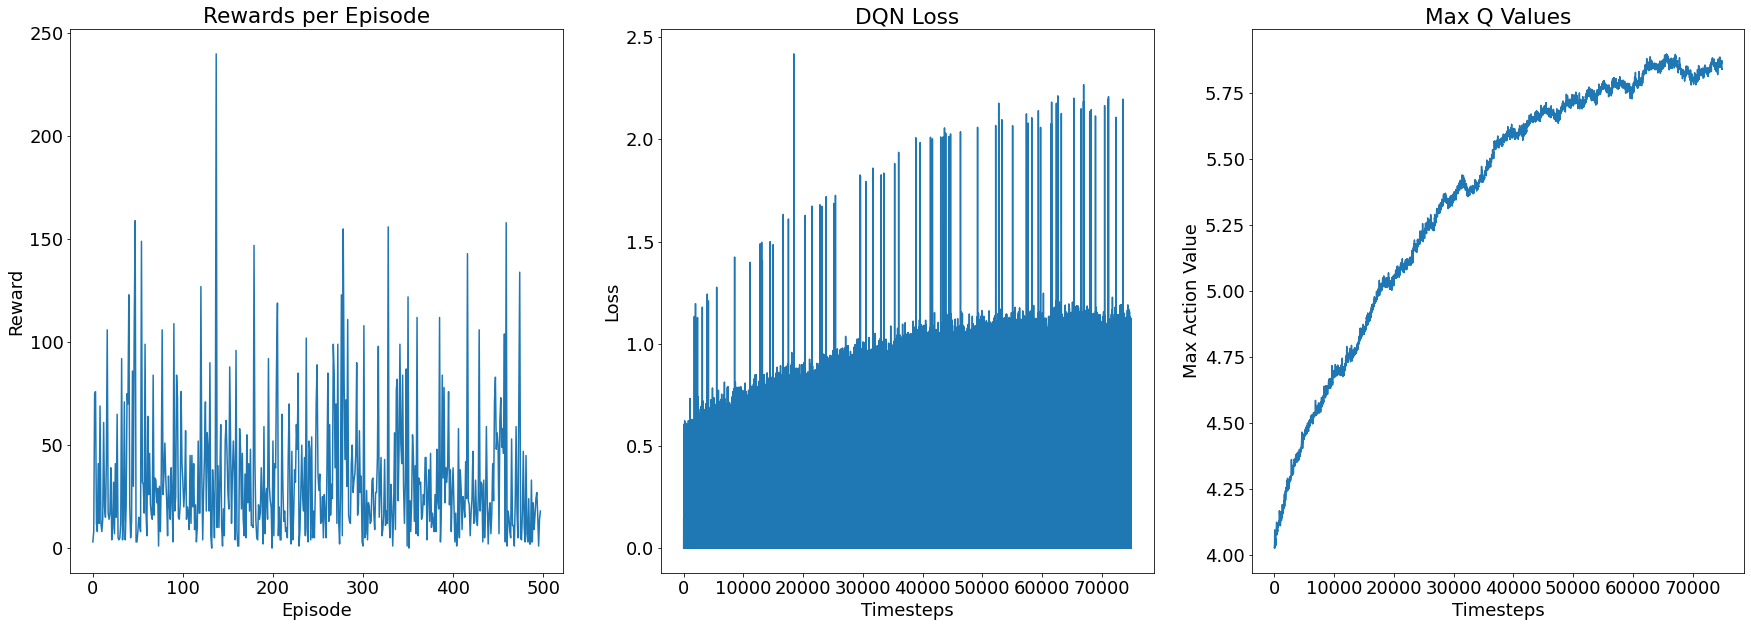

In [32]:
loss = []
rewards = []
episode_reward = 0
replay_initial = 50000
replay_buffer = ReplayBuffer(hyp.replay_buffer_max_length)
max_q_vals = np.array([])
state=env.reset()
get_eps = get_epsilon(start=hyp.epsilon_start,
                      end=hyp.epsilon_end,
                      decay_length=hyp.epsilon_decay_period)



for timestep in range(1,hyp.num_iterations):
  
  action, max_q_val = online_network.act(state=state,epsilon=eps)
  
  next_state, reward, done, _ = env.step(action)
  replay_buffer.push(state,action,reward,next_state,done)

  
  state = next_state
  episode_reward+=reward

  if done:
    state=env.reset()
    rewards.append(episode_reward)
    episode_reward=0
    plot(rewards,loss,max_q_vals)

  if len(replay_buffer)>replay_initial ==0:
    eps=next(get_eps)
    if timestep%hyp.update_freq==0:
    max_q_vals = np.append(max_q_vals,max_q_val)
    td_loss = compute_td_loss(gamma=hyp.gamma,
                              batch_size=hyp.batch_size)
    loss.append(td_loss)
  
  if timestep % hyp.target_update_period==0:
    update_target(online_network,target_network)

  if timestep % hyp.log_interval == 0:
    torch.save(online_network.state_dict(), save_online_path)


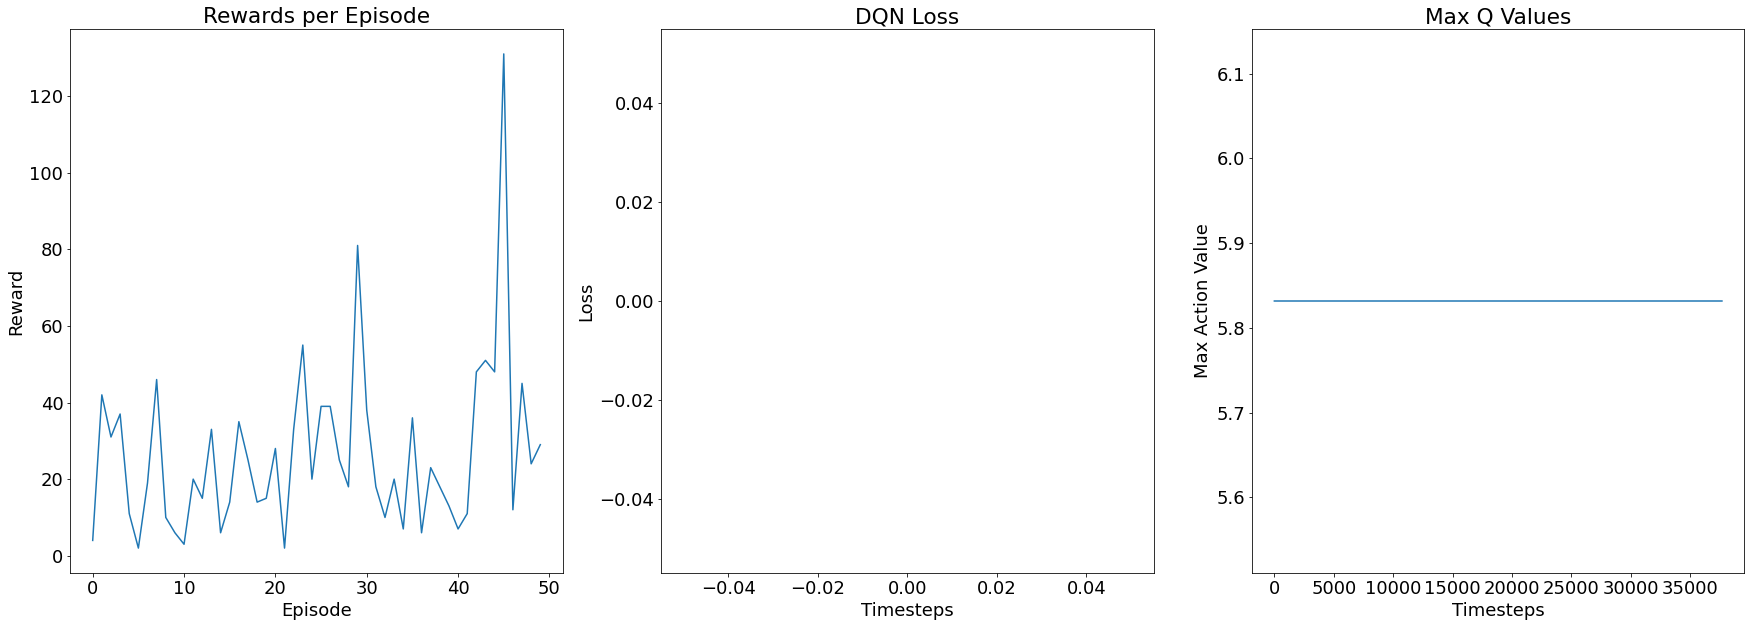

Average Eval Reward:[4.0, 42.0, 31.0, 37.0, 11.0, 2.0, 19.0, 46.0, 10.0, 6.0, 3.0, 20.0, 15.0, 33.0, 6.0, 14.0, 35.0, 25.0, 14.0, 15.0, 28.0, 2.0, 33.0, 55.0, 20.0, 39.0, 39.0, 25.0, 18.0, 81.0, 38.0, 18.0, 10.0, 20.0, 7.0, 36.0, 6.0, 23.0, 18.0, 13.0, 7.0, 11.0, 48.0, 51.0, 48.0, 131.0, 12.0, 45.0, 24.0, 29.0]


In [33]:
online_network=ConvDQN(env.observation_space.shape, env.action_space.n)
hyp=hasselt_hyp()
try:
  online_network.load_state_dict(torch.load(save_online_path))
  print('Using model from {}'.format(save_online_path))
except:
  pass
  
if USE_CUDA:
  print('Using GPU')
  online_network = online_network.cuda()
eval_rewards = []
max_q_vals = np.array([])
loss = []
eps = 0.05
episode_reward = 0
state = env.reset()
done=0
for eval_ep in range(hyp.num_eval_episodes):
  while not done:
    action, max_q_val = online_network.act(state=state,epsilon=eps)
    max_q_vals = np.append(max_q_vals, max_q_val)
    next_state, reward, done, _ = env.step(action)

    episode_reward+=reward
    state=next_state

  
  eval_rewards.append(episode_reward)
  episode_reward=0
  done=0
  plot(eval_rewards,[],max_q_vals)
  state=env.reset()
print('Average Eval Reward:{}'.format(eval_rewards))

Text(0, 0.5, 'Reward')

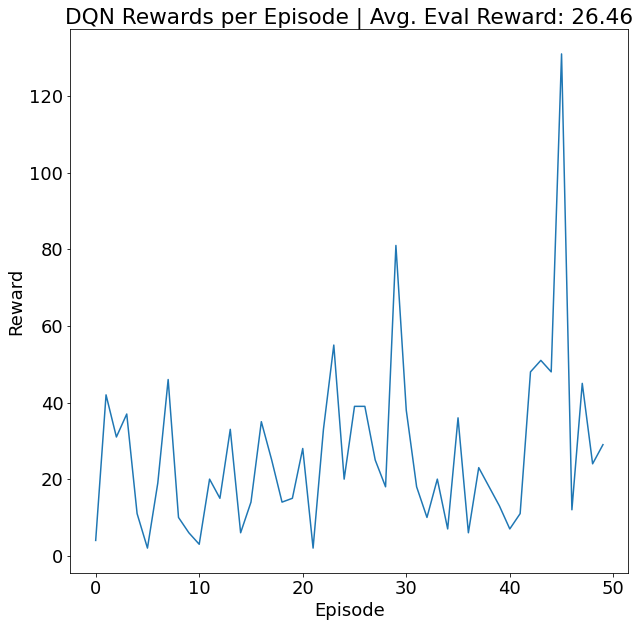

In [34]:
fig,ax = plt.subplots(figsize=(10,10))

ax.plot(eval_rewards)
ax.set_title('DQN Rewards per Episode | Avg. Eval Reward: {}'.format(np.mean(eval_rewards)))
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')